<h1><center><u> Portfolio Optimization </u></center></h1>

<h3 style="color:blue;"> (1) Import Python Libraries </h3>

In [1]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt

from pprint import pprint
from sklearn.preprocessing import StandardScaler

from pandas_datareader import data as web
from datetime import datetime
from alpha_vantage.timeseries import TimeSeries
import time

In [27]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('expand_frame_repr', False)

<ipython-input-27-eb736239aa8c>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


<h3 style="color:blue;"> (2) Loading the Data Set </h3>

In [45]:
assets = ['META', 'AMZN', 'AAPL', 'NFLX', 'GOOGL', 'MSFT']
number_of_assets = len(assets)

In [54]:
api_key = 'HWI0SV3ZF6AMLE1D'
ts = TimeSeries(key=api_key, output_format='pandas')

In [49]:
df = pd.DataFrame(columns=['date', 'symbol', 'volume', 'close', 'open', 'high', 'low'])

for stock in assets:
    df_stock, _ = ts.get_daily(symbol=stock, outputsize='full')
    df_stock.rename(columns={'4. close': 'close', '1. open': 'open', '2. high': 'high', '3. low': 'low', '5. volume': 'volume'}, inplace=True)
    df_stock['symbol'] = stock
    df_stock['date'] = df_stock.index
    df = df.append(df_stock[['date', 'symbol', 'volume', 'close', 'open', 'high', 'low']], ignore_index=True)
    
    time.sleep(12)
    
csv_filename = 'stock_data.csv'
df.to_csv(csv_filename, index=False)
print(f"Data saved to {csv_filename}")

Data saved to stock_data.csv


In [3]:
path = r"D:\IITG\portfolio_finance\portfolio_optimization\stock_data.csv"
price_data_frame: pd.DataFrame = pd.read_csv(path)
price_data_frame.head()

,date,symbol,volume,close,open,high,low
0,2023-08-21,META,20181475.0,289.90,283.450,290.50,281.85
1,2023-08-18,META,35347925.0,283.25,279.030,285.69,274.38
2,2023-08-17,META,23950089.0,285.09,293.050,296.05,284.95
3,2023-08-16,META,18547741.0,294.29,300.195,301.08,294.28
4,2023-08-15,META,11623613.0,301.95,306.140,307.23,300.03


<h3 style="color:blue;"> (3) Cleaning the Data </h3>

In [4]:
stockStartDate = '2015-01-01'
today = datetime.today().strftime('%Y-%m-%d')

In [5]:
price_data_frame = price_data_frame[['date', 'symbol', 'close']]
price_data_frame = price_data_frame[(price_data_frame['date'] >= stockStartDate) & (price_data_frame['date'] <= today)]

In [6]:
price_data_frame = price_data_frame.pivot(
    index='date',
    columns='symbol',
    values='close'
)

price_data_frame.head()

symbol,AAPL,AMZN,GOOG,META,MSFT,NFLX
date,,,,,,
2015-01-02,109.33,308.52,524.81,78.450,46.760,348.940
2015-01-05,106.25,302.19,513.87,77.190,46.325,331.180
2015-01-06,106.26,295.29,501.96,76.150,45.650,325.510
2015-01-07,107.75,298.42,501.10,76.150,46.230,327.200
2015-01-08,111.89,300.46,502.68,78.175,47.590,334.455


***
<h3 style="color:blue;"> (4) Calculating Sharpe Ratio </h3>

The `Sharpe Ratio`, is used is a measure for calculating risk-adjusted return and has been the industry standard for such calculations. The `Sharpe Ratio` allows us to quantify the relationship the average return earned in excess of the risk-free rate per unit of volatility or total risk.

Mathematically, we define the `Sharpe Ratio` as the following:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

Where:

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$

To calculate the `expected returns`, we use the following formula:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

Where:

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

To calculate the `standard deviation of the portfolio`, we use the following formula:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}

Where:

$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$

In [48]:
# Calculate the Log of returns.
log_return = np.log(1 + price_data_frame.pct_change())
log_return.head()

symbol,AAPL,AMZN,GOOG,META,MSFT,NFLX
date,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.028576,-0.020731,-0.021066,-0.016192,-0.009346,-0.052238
2015-01-06,0.000094,-0.023098,-0.023450,-0.013565,-0.014678,-0.017269
2015-01-07,0.013925,0.010544,-0.001715,0.000000,0.012625,0.005178
2015-01-08,0.037703,0.006813,0.003148,0.026245,0.028994,0.021931


In [49]:
# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_assets))
random_weights

array([0.19438222, 0.08157005, 0.81494142, 0.65581664, 0.97832522,
       0.54393883])

In [50]:
# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)
rebalance_weights

array([0.05946276, 0.0249528 , 0.24929575, 0.20061847, 0.29927589,
       0.16639434])

In [51]:
# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)
exp_ret

0.060717761915546134

In [52]:
# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)
exp_vol

0.39190876828430865

In [53]:
# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol
sharpe_ratio

0.1549283068642615

In [54]:
# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*50)
print('PORTFOLIO WEIGHTS:')
print('-'*50)
print(weights_df)
print('-'*50)


PORTFOLIO WEIGHTS:
--------------------------------------------------
   random_weights  rebalance_weights
0  0.194382        0.059463         
1  0.081570        0.024953         
2  0.814941        0.249296         
3  0.655817        0.200618         
4  0.978325        0.299276         
5  0.543939        0.166394         
--------------------------------------------------


In [55]:
# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*90)
print('PORTFOLIO METRICS:')
print('-'*90)
print(metrics_df)
print('-'*90)


PORTFOLIO METRICS:
------------------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0  0.060718                    0.391909                       0.154928              
------------------------------------------------------------------------------------------


***
<h3 style="color:blue;"> (5) Portfolio Optimization : Running Monte Carlo Simulation </h3>

Monte Carlo simulations are used to model the probability of different outcomes in a process that cannot easily be predicted due to the intervention of random variables. It is a technique used to understand the impact of risk and uncertainty in prediction and forecasting models.

In [56]:
# We will run 5000 iterations.
num_of_portfolios = 5000

In [58]:
# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_assets))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

In [59]:
# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_assets))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [65]:
# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = ['Returns', 'Volatility', 'Sharpe Ratio', 'Portfolio Weights']

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

simulations_df.head()

,Returns,Volatility,Sharpe Ratio,Portfolio Weights
0,0.037474,0.403915,0.092778,"[0.15760031320746729, 0.2521816043266357, 0.13442656261036467, 0.1613812251140267, 0.2193196901918524, 0.07509060454965322]"
1,0.101986,0.364177,0.280045,"[0.161912130351683, 0.01444301121439593, 0.0187123767963907, 0.30223935976837063, 0.206711820594815, 0.29598130127434474]"
2,0.039241,0.379845,0.103308,"[0.24284465697753363, 0.07558232995370391, 0.16903906861362336, 0.1186067412841262, 0.17259667376572496, 0.2213305294052879]"
3,0.051213,0.389795,0.131384,"[0.05425825934348524, 0.19139141595587986, 0.09869162365766704, 0.27476310180423524, 0.16581580043975436, 0.2150797987989784]"
4,0.010418,0.453962,0.022950,"[0.0911606195984837, 0.24414633884271253, 0.13606032908716834, 0.07754506319337028, 0.15102577822124463, 0.3000618710570206]"


### Grabbing the Important Metrics

**`max_sharpe_ratio`:** This is Sharpe Ratio where the excess return of the portfolio is greatest given the amount of risk we are taking on. In other words, these portfolios are "best" because they provide the largest risk-adjusted returns.

**`min_volatility`:** These are the weights where the overall volatility of the portfolio is at it's lowest. In other words, if you want to take on the least amount of risk, these are the weights you would want to have. 

In [70]:
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns              0.165343                                                                                                                        
Volatility           0.291222                                                                                                                        
Sharpe Ratio         0.567755                                                                                                                        
Portfolio Weights    [0.25356877302148945, 0.010627637935533044, 0.0011785495421920082, 0.15387190616798102, 0.577131546194449, 0.003621587138355487]
Name: 2723, dtype: object
--------------------------------------------------------------------------------


In [71]:
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns              0.15261                                                                                                                          
Volatility           0.290849                                                                                                                         
Sharpe Ratio         0.524704                                                                                                                         
Portfolio Weights    [0.19961213707555278, 0.013596448286011475, 0.005093923130234636, 0.30964496520514867, 0.42889604911671464, 0.043156477186337854]
Name: 1310, dtype: object
--------------------------------------------------------------------------------


### Plotting: Risk v/s Returns

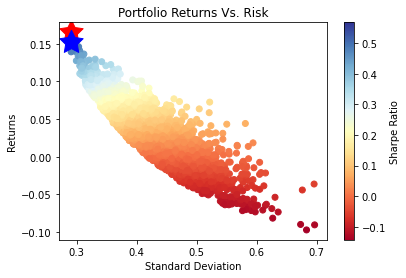

In [73]:
%matplotlib inline

plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

plt.show()

***
<h3 style="color:blue;"> (6) Portfolio Optimization : Using Scipy Optimization Module </h3>

The draw back to using the Monte Carlo Simulation is that it's not the most efficient way to find the optimal values. Instead we can use mathematical techniques to easily arrive at the optimal values. We run the optimization using the `scipy.optimization` module.

The first function is the `get_metrics()` function which will return the metrics for a given set of weights provided. In other words, think of it as a "lookup function" where we can return the results of a certain weight. The second function is the `grab_negative_sharpe()` function which is used as a minimization function. The minimization function is used to help find the values which results in the lowest sharpe ratio. In Scipy’s optimize function, there’s no `maximize`, so as an objective function you need to pass something that should be minimized.

The third function is `check_sum` function which is used as a constraint. What is will do is make sure that the weights that are passed through meet the constraint that we must have a portfolio allocation equal 100%, not more and not less.

In [74]:
def get_metrics(weights: list) -> np.array:
    
    weights = np.array(weights)

    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )
    sr = ret / vol

    return np.array([ret, vol, sr])

In [101]:
def grab_negative_sharpe(weights: list) -> np.array:
    return -(1 + get_metrics(weights)[2]) 

def grab_volatility(weights: list) -> np.array:
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    return np.sum(weights) - 1

***
Let's run the optimization using the `scipy.optimization` module. This module has a function called `minimize` which we can use to help our optimal values. we can run the optimization by passing through the arguments defined and defining the `method` as `SLSQP` which is short for `Sequential Least Squares Programming`.

In [102]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_assets))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with, and usually the best initial guess is just an even distribution.
init_guess = number_of_assets * [1 / number_of_assets]

### Maximizing Sharpe Ratio

In [103]:
# Perform the operation to minimize the risk.

optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

In [104]:
print('')
print('='*90)
print('OPTIMIZED SHARPE RATIO:')
print('-'*90)
print(optimized_sharpe)
print('-'*90)


OPTIMIZED SHARPE RATIO:
------------------------------------------------------------------------------------------
     fun: -1.7962099152537103
     jac: array([ 0.41213581,  0.98618677,  1.21474755,  0.09539299, -0.        ,
        0.53260311])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([1.59990393e-16, 7.77383541e-16, 4.84604742e-16, 0.00000000e+00,
       1.00000000e+00, 5.23484780e-16])
------------------------------------------------------------------------------------------


### Grabbing the Important Metrics

In [105]:
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

In [106]:
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[1.59990393e-16 7.77383541e-16 4.84604742e-16 0.00000000e+00
 1.00000000e+00 5.23484780e-16]
--------------------------------------------------------------------------------


In [107]:
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.22382411 0.28111194 0.79620992]
--------------------------------------------------------------------------------


### Minimizing Risk (Volatility)

In [96]:
# Perform the operation to minimize the risk.

optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

In [97]:
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)


OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
     fun: 0.2738308506943697
     jac: array([0.27380429, 0.27398584, 0.27392484, 0.27383472, 0.27383466,
       0.27362216])
 message: 'Optimization terminated successfully'
    nfev: 56
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([0.06093243, 0.00994952, 0.01096501, 0.13513252, 0.76205518,
       0.02096535])
--------------------------------------------------------------------------------


### Grabbing the Important Metrics

In [98]:
optimized_metrics = get_metrics(weights=optimized_volatility.x)

In [99]:
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.06093243 0.00994952 0.01096501 0.13513252 0.76205518 0.02096535]
--------------------------------------------------------------------------------


In [100]:
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.19205796 0.27383085 0.70137444]
--------------------------------------------------------------------------------
